In [38]:
## Libraries
import glob
from multiprocessing import cpu_count
import os
import random
import sys

## 3rd party
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

_path = ".."
if _path not in sys.path:
    sys.path.append(_path)
from lib.dataset import TextArtDataLoader, AlignCollate, ImageBatchSampler
from lib.config import Config
# from lib.preprocess import (pad_image, crop_edges_lr, )

%reload_ext autoreload
%autoreload 2

In [39]:
BATCH_SIZE = 4
# N_WORKERS = cpu_count() - 1
N_WORKERS = 0
CONFIG = Config()

In [40]:
train_dataset = TextArtDataLoader(CONFIG, mode='train')
# val_dataset = TextArtDataLoader(CONFIG, mode='val')
# test_dataset = TextArtDataLoader(CONFIG, mode='test')

train_align_collate = AlignCollate(CONFIG, 'train')
# val_align_collate = AlignCollate(CONFIG, 'val')

train_batch_sampler = ImageBatchSampler(CONFIG, mode='train')
# val_batch_sampler = ImageBatchSampler(CONFIG, mode='val')

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=train_align_collate,
                          sampler=train_batch_sampler,
                         )
# val_loader = DataLoader(val_dataset,
#                           batch_size=BATCH_SIZE,
#                           shuffle=False,
#                           num_workers=N_WORKERS,
#                           pin_memory=True,
#                           collate_fn=val_align_collate,
#                           sampler=val_batch_sampler
#                          )
# test_loader = DataLoader(test_dataset,
#                           batch_size=BATCH_SIZE,
#                           shuffle=False,
#                           num_workers=N_WORKERS,
#                           pin_memory=True,
#                           collate_fn=None,
#                          )

In [11]:
class InvNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


WVs
theropod/0.881 prehistoric/0.925 dinosaur/0.891 animal/0.628 dinosaur/0.410 

head/0.936 hairy/0.908 animal/0.845 bird/0.791 race/0.405 

horse/0.970 animal/0.956 gray/0.977 animal/1.000 candy/0.445 

animal/0.794 mare/0.954 horse/0.868 white/0.937 cartography/0.456 

-------------

Fake WVs
sinai/1.000 mer/1.000 isaiah/1.000 link/1.000 trophy/1.000 

wait/1.000 amour/1.000 maeterlinck/1.000 borodin/1.000 aleksandrovskoe/1.000 

colonnade/1.000 aleksandrovskoe/1.000 plantation/1.000 fetish/1.000 dresden/1.000 

league/1.000 sacrament/1.000 hiveswap/1.000 cloisonnism/1.000 judaism/1.000 



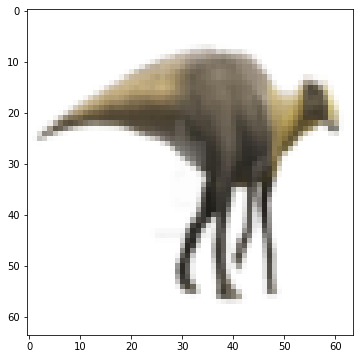

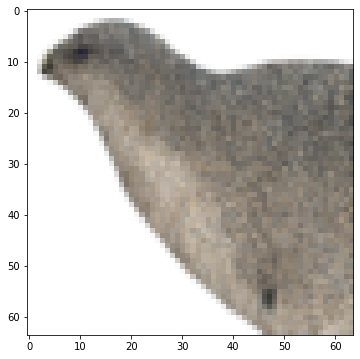

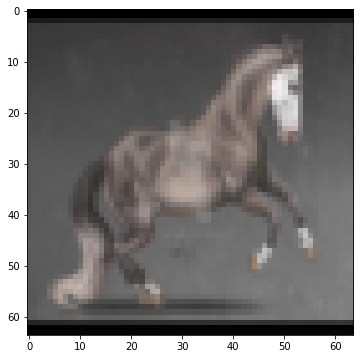

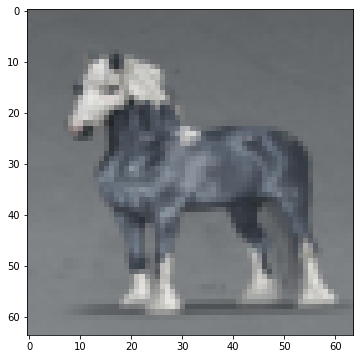

In [13]:
inv_normalize = InvNormalize(CONFIG.MEAN, CONFIG.STD)
for i, (images, wv_tensor, fake_wv_tensor) in enumerate(train_loader):

#     for image in images:
#         print(image)
#         print("MIN:", image.min())
#         print("MAX:", image.max())
#         print()

#     print("IMAGE:", images.shape)
#     print("WV:", wv_tensor.shape)
#     print("Fake WV:", fake_wv_tensor.shape)
    
    print("\nWVs")
    for wvs in wv_tensor:
        for wv in wvs:
            wv = np.array(wv)
            word, prob = train_loader.dataset.word2vec_model.wv.similar_by_vector(wv)[0]
            print("{}/{:.3f}".format(word, prob), end=' ')
        print('\n')
    
    print("-------------")
    print("\nFake WVs")
    for fake_wvs in fake_wv_tensor:
        for fake_wv in fake_wvs:
            fake_wv = np.array(fake_wv)
            fake_word, prob = train_loader.dataset.word2vec_model.wv.similar_by_vector(fake_wv)[0]
            print("{}/{:.3f}".format(fake_word, prob), end=' ')
        print('\n')
    
    for image in images:
        image = inv_normalize(image)
        image = np.array(image)
        image = image.transpose(1, 2, 0)
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.show()
    break

In [54]:
from PIL import Image, ImageDraw, ImageFont
def words2image(text_list, n_column=1):
    config = Config()

    w = config.IMAGE_SIZE_WIDTH
    h = config.IMAGE_SIZE_HEIGHT

    img = Image.fromarray(np.ones((h, w)))
    draw = ImageDraw.Draw(img)

    ## Look for fonts
    for font in config.FONTS:
        try:
            font = ImageFont.truetype(font, 9)
        except OSError:
            continue
    
    if n_column == 1:
        
        x0 = int(w * 0.001)
        y0 = int(h * 0.001)
        word_height = h // len(text_list)
        for i, text in enumerate(text_list):
            y = i * word_height + y0
            x = x0
            draw.text((x, y), text, 0, font=font)

    elif n_column == 2:
        
        x1 = int(w * 0.01)
        x2 = int(w * 0.51)
        y0 = int(h * 0.01)
        word_height = h // len(text_list) * 2
        for i, text in enumerate(text_list):
            y = (i // 2) * word_height + y0 if i % 2 == 0 else (i - 1) // 2 * word_height + y0
            x = x1 if i % 2 == 0 else x2
            draw.text((x, y), text, 0, font=font)
            
    else:
        print("'words2image': Column {} not implemented".format(n_column))
        raise NotImplemented

    return np.array(img.convert('RGB')) * 255

In [55]:
images_bag = []
for i, (fake_image, real_wvs) in enumerate(zip(images, wv_tensor)):
    words = []
    for real_wv in real_wvs:
        real_wv = np.array(real_wv)
        word, prob = train_dataset.word2vec_model.wv.similar_by_vector(real_wv)[0]
        words.append(word)

    fake_image = np.array(fake_image).transpose(1, 2, 0)
    word_image = words2image(words)
    
    images_bag.extend([word_image, fake_image])
    
images_bag = np.array(images_bag)
words = np.unique(words)

In [24]:
## Test image batch sampling
sampler = ImageBatchSampler(CONFIG)
# for i in range(len(train_dataset)):
#     x = "/".join(train_dataset[i][2].split('/')[-4:])
#     y = sampler.df[sampler.df['index'] == i]['image_file'].iloc[0]
#     if x != y:
#         print(x, y)
#         break